In [12]:
import awkward as ak
import os
import numpy as np
import uproot
import nbimporter
import import_ipynb
import matplotlib.pyplot as plt
import seaborn as sns
from hffrag import fixedbinning
from hffrag import binneddensity
from numpy.lib.recfunctions import structured_to_unstructured
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.ensemble import RandomForestRegressor
import DeepSetNeuralNetArchitecture

In [3]:
%matplotlib inline 

In [4]:
path = "/home/physics/phujdj/DeepLearningParticlePhysics/CheckPoints/DeepNetWeights&Biases-{epoch:04d}.ckpt"
checkpoint = os.path.dirname(path)
latest_DeepNet = tf.train.latest_checkpoint(checkpoint)


In [5]:
#The data is being stored in a tree datastructure. 
#We access the charm root using this command
tree = uproot.open("hffrag.root:CharmAnalysis")

In [7]:
MAXEVENTS = 1e20
MAXTRACKS = 32
LR = 5e-3

In [8]:
#Read in the data from the root file
track_features = ["AnalysisTracks_pt","AnalysisTracks_eta","AnalysisTracks_phi","AnalysisTracks_z0sinTheta","AnalysisTracks_d0sig","AnalysisTracks_d0","AnalysisTracks_d0sigPV","AnalysisTracks_d0PV"]
jet_features = ["AnalysisAntiKt4TruthJets_pt", "AnalysisAntiKt4TruthJets_eta", "AnalysisAntiKt4TruthJets_phi",
                "AnalysisAntiKt4TruthJets_ghostB_pt", "AnalysisAntiKt4TruthJets_ghostB_eta","AnalysisAntiKt4TruthJets_ghostB_phi"]
features = tree.arrays(jet_features+track_features,entry_stop = MAXEVENTS)

In [9]:
#Select the events of interest
events = features[ak.sum(features["AnalysisAntiKt4TruthJets_pt"] > 25000, axis = 1) > 0]

In [10]:
#Displays the number of jets being trained on
jets = events[jet_features][:,0]
print("The number of jets to train on is: ", len(jets))

#Select tracks from the events
tracks = events[track_features]

#Match the tracks to the jets
matchedtracks = tracks[DeepSetNeuralNetArchitecture.Match_Tracks(jets,tracks)]

#Pad and Flatten the data
matchedtracks = DeepSetNeuralNetArchitecture.flatten(matchedtracks, MAXTRACKS)

# Identify the the bottom jets and their associated tracks
bjets = ak.sum(jets["AnalysisAntiKt4TruthJets_ghostB_pt"] > 5000, axis=1) > 0
jets = jets[bjets]
bhads_pt = jets["AnalysisAntiKt4TruthJets_ghostB_pt"][:, 0].to_numpy()
bhads_eta = jets["AnalysisAntiKt4TruthJets_ghostB_eta"][:,0].to_numpy()
bhads_phi = jets["AnalysisAntiKt4TruthJets_ghostB_phi"][:,0].to_numpy()
bhads = np.stack([bhads_pt,bhads_eta,bhads_phi],axis = -1)

print("There are {} outputs".format(np.shape(bhads)[1]))
matchedtracks = matchedtracks[bjets]
print("There are {} inputs".format(np.shape(matchedtracks)[1]))

#Transform the jet and tracks to unstructed data.
jets = structured_to_unstructured(jets[jet_features[:-3]])
matchedtracks = structured_to_unstructured(matchedtracks)

#Fix the angles
jets = DeepSetNeuralNetArchitecture.pt_eta_phi_2_px_py_pz_jets(jets).to_numpy()
tracks_p = DeepSetNeuralNetArchitecture.pt_eta_phi_2_px_py_pz_tracks(matchedtracks.to_numpy())
bhads = DeepSetNeuralNetArchitecture.pt_eta_phi_2_px_py_pz_jets(bhads)
print(np.shape(tracks_p))
print(np.shape(matchedtracks[:, :, 3:]))
tracks = np.concatenate([tracks_p,matchedtracks[:,:,3:].to_numpy()],axis = 2)

The number of jets to train on is:  141329
There are 3 outputs
There are 32 inputs
(68143, 32, 3)
(68143, 32, 5)


/home/physics/phujdj/DeepLearningParticlePhysics/DeepSetNeuralNetArchitecture.py:99: RuntimeWarning: overflow encountered in sinh
  pzs = np.where(mask1 | mask3, pts, pts * np.sinh(etas))


In [11]:
#Load the training and validation data
X_train = np.load("/home/physics/phujdj/DeepLearningParticlePhysics/TrainingAndValidationData/X_train_data.npy")
X_valid = np.load("/home/physics/phujdj/DeepLearningParticlePhysics/TrainingAndValidationData/X_valid_data.npy")
y_train = np.load("/home/physics/phujdj/DeepLearningParticlePhysics/TrainingAndValidationData/y_train_data.npy")
y_valid = np.load("/home/physics/phujdj/DeepLearningParticlePhysics/TrainingAndValidationData/y_valid_data.npy")

In [14]:
#Cyclical Learning Rate Scheduler:
steps_per_epoch = len(X_train)
clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate = 1e-4,
maximal_learning_rate = 1e-3,
scale_fn = lambda x: 0.90 ** x,
step_size = 2.0 * steps_per_epoch
)
optimizer = tf.keras.optimizers.Adam(clr)

#Builds the deep neural network
track_layers = [32,32,32,32,32]
jet_layers = [64,64,64,64,64]
DeepNet = DeepSetNeuralNetArchitecture.DeepSetNeuralNetwork(
    [len(track_features)]+track_layers, jet_layers,3,optimizer)
DeepNet.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, 8)]         0         
                                                                 
 masking_1 (Masking)         (None, None, 8)           0         
                                                                 
 time_distributed_6 (TimeDis  (None, None, 8)          72        
 tributed)                                                       
                                                                 
 dropout_10 (Dropout)        (None, None, 8)           0         
                                                                 
 batch_normalization_10 (Bat  (None, None, 8)          32        
 chNormalization)                                                
                                                                 
 time_distributed_7 (TimeDis  (None, None, 32)         288 

In [15]:
DeepNet.load_weights(latest_DeepNet)
#Specify the neural network's optimizer and loss function
#loss = DeepNet.evaluate(tracks,bhads,verbose = 2)
#print("The Loaded DeepNet has loss: ", round(loss,3))

In [16]:
# Have the model predict the total momentum of the b tracks
predictions = DeepNet.predict(tracks)
predictions_train = DeepNet.predict(X_train)
predictions_valid = DeepNet.predict(X_valid)

639/639 [==============================] - 1s 1ms/step


In [17]:
# Output the first 10 guesses
print(predictions[:10])
print(np.shape(predictions))
print(bhads[:10])

[[ -9.629226    52.00521    -60.736183    10.529499    11.080706
   11.447428     0.5545816   -1.5267669    1.5097891 ]
 [ -8.6588335   51.380753   -54.61213      9.93066     11.125513
   11.962849     0.30880266  -1.3137546    2.176897  ]
 [ -8.844546    54.79321    -62.39228     10.930727    11.290168
   12.371041     0.47906074  -1.5982319    1.6717561 ]
 [ -9.701789    50.94707    -60.19525     10.375596    10.899517
   11.124055     0.5675043   -1.5085044    1.4320413 ]
 [ -9.6773405   51.72916    -61.984848    10.633328    10.971652
   11.232888     0.60924745  -1.5809488    1.3269687 ]
 [ -9.77832     51.8349     -61.264378    10.55939     11.062739
   11.314977     0.5812167   -1.5403763    1.4283147 ]
 [ -7.4522276   51.37245    -58.680683    10.643298    10.701567
   11.863013     0.5500614   -1.5520945    1.5378401 ]
 [ -9.118356    52.208023   -61.025467    10.678878    11.043522
   11.600635     0.5728452   -1.5589077    1.4698843 ]
 [ -8.703945    51.29327    -65.01849   

In [18]:
# Output the first 10 guesses
print(predictions_train[:10])
print(np.shape(predictions_train))
print(y_train[:10])

[[ -7.153273    52.496586   -62.34338     10.8896265   10.36812
   11.893178     0.54205763  -1.6801779    1.361458  ]
 [ -9.757704    50.877583   -56.683617    10.0150175   11.166049
   11.421332     0.41847926  -1.3252637    1.8668373 ]
 [ -8.205325    51.331516   -64.88978     10.968811    10.301773
   11.171245     0.6034394   -1.7129575    0.99483883]
 [ -7.1647425   50.579346   -60.75674     10.796609    10.362137
   11.516758     0.58075064  -1.6150533    1.2427331 ]
 [ -9.700532    51.684017   -63.647552    10.788211    10.873726
   11.077994     0.64766157  -1.6452512    1.1432611 ]
 [ -9.117113    53.250904   -63.17978     10.956521    11.106813
   11.759762     0.5927133   -1.6305873    1.3658915 ]
 [-10.1543865   51.885094   -63.97247     10.737825    10.937125
   10.998082     0.6454586   -1.6415849    1.151487  ]
 [ -9.795465    65.99229    -74.36919     11.002554    10.931526
   13.911629     0.25491548  -2.1478424    2.3689501 ]
 [ -9.1858425   54.513187   -63.430027   

In [19]:
# Output the first 10 guesses
print(predictions_valid[:10])
print(np.shape(predictions_valid))
print(y_valid[:10])

[[ -9.020357    50.743824   -57.159573    10.200264    10.984076
   11.473793     0.48907414  -1.3999186    1.7237191 ]
 [ -9.68306     51.35258    -61.01744     10.519795    10.972716
   11.195375     0.59427434  -1.5386677    1.3840812 ]
 [ -9.701128    51.043163   -58.635147    10.271729    11.088939
   11.313784     0.5178662   -1.4214437    1.6242368 ]
 [ -9.17728     50.69569    -58.78963     10.341845    10.902636
   11.284828     0.5517382   -1.4675593    1.5263404 ]
 [ -9.954443    51.284863   -62.244923    10.581076    10.923102
   11.003142     0.6249809   -1.5796392    1.2514406 ]
 [ -8.6567      51.867188   -55.971256    10.065518    11.067417
   11.9926195    0.34814432  -1.3951814    2.0826418 ]
 [ -7.8667808   49.55951    -61.81837     10.720285    10.249225
   10.994525     0.6075693   -1.6266224    1.0507492 ]
 [ -9.3444605   52.716267   -64.70997     11.003148    10.920861
   11.395667     0.63775295  -1.6852455    1.1518799 ]
 [ -7.6837516   50.685062   -59.858467  

In [20]:
#Assesses the error and pull in the transverse momentum predictions by the neural network
error_px_train = (predictions_train[:, 0] - y_train[:,0])
pull_px_train = error_px_train/np.exp(predictions_train[:, 3])

# Compares and constrasts the true and predicted momentums
print(np.min(predictions_train[:,0]),np.max(predictions_train[:,0]))

print("Mean and standard deviation")
print("The mean/std for the ppred - ptrue: ", np.mean(error_px_train), np.std(error_px_train))
print("The mean/std for the pull", np.mean(pull_px_train), np.std(pull_px_train))


-14.634578 -5.566692
Mean and standard deviation
The mean/std for the ppred - ptrue:  -121.13512600128037 65288.94990380159
The mean/std for the pull 0.07249244114663582 1.172998866301385


In [21]:
print(np.shape(predictions_valid))
print(np.shape(X_valid))
print(np.shape(y_valid))

(20443, 9)
(20443, 32, 8)
(20443, 3)


In [22]:
#Assesses the error and pull in the transverse momentum predictions by the neural network
error_px_valid = (predictions_valid[:, 0] - y_valid[:,0])
pull_px_valid = error_px_valid/np.exp(predictions_valid[:, 3])

# Compares and constrasts the true and predicted momentums
print(np.min(predictions_valid[:,0]),np.max(predictions_valid[:,0]))

print("Mean and standard deviation")
print("The mean/std for the ppred - ptrue: ", np.mean(error_px_valid), np.std(error_px_valid))
print("The mean/std for the pull", np.mean(pull_px_valid), np.std(pull_px_valid))

-14.127123 -5.6058803
Mean and standard deviation
The mean/std for the ppred - ptrue:  -123.15233763392105 64962.772330908076
The mean/std for the pull 0.07137191960221409 1.17373802538868


In [23]:
#Assesses the error and pull in the transverse momentum predictions by the neural network
error_px = (predictions[:, 0] - bhads[:,0])
pull_px = error_px/np.exp(predictions[:, 3])

# Compares and constrasts the true and predicted momentums
print(np.min(predictions[:,0]),np.max(predictions[:,0]))

print("Mean and standard deviation")
print("The mean/std for the ppred - ptrue: ", np.mean(error_px), np.std(error_px))
print("The mean/std for the pull", np.mean(pull_px), np.std(pull_px))

-14.634578 -5.566692
Mean and standard deviation
The mean/std for the ppred - ptrue:  -121.74029245133491 65191.26751997857
The mean/std for the pull 0.0721562830389415 1.1732207763800062


In [24]:
#Assesses the error and pull in the transverse momentum predictions by the neural network
error_py_train = (predictions_train[:, 1] - y_train[:,1])
pull_py_train = error_py_train/np.exp(predictions_train[:, 4])

# Compares and constrasts the true and predicted momentums
print(np.min(predictions_train[:,1]),np.max(predictions_train[:,1]))

print("Mean and standard deviation")
print("The mean/std for the ppred - ptrue: ", np.mean(error_py_train), np.std(error_py_train))
print("The mean/std for the pull", np.mean(pull_py_train), np.std(pull_py_train))

48.648106 65.99229
Mean and standard deviation
The mean/std for the ppred - ptrue:  232.81459338883093 65564.54754732574
The mean/std for the pull -0.07981872607951548 1.017134709854445


In [25]:
#Assesses the error and pull in the transverse momentum predictions by the neural network
error_py_valid = (predictions_valid[:, 1] - y_valid[:,1])
pull_py_valid = error_py_valid/np.exp(predictions_valid[:, 4])

# Compares and constrasts the true and predicted momentums
print(np.min(predictions_valid[:,1]),np.max(predictions_valid[:,1]))

print("Mean and standard deviation")
print("The mean/std for the ppred - ptrue: ", np.mean(error_py_valid), np.std(error_py_valid))
print("The mean/std for the pull", np.mean(pull_py_valid), np.std(pull_py_valid))

49.020237 65.99229
Mean and standard deviation
The mean/std for the ppred - ptrue:  -131.083446818861 65089.89592355961
The mean/std for the pull -0.08302935551909252 1.0117968418038967


In [26]:
#Assesses the error and pull in the transverse momentum predictions by the neural network
error_py = (predictions[:, 1] - bhads[:,1])
pull_py = error_py/np.exp(predictions[:, 4])

# Compares and constrasts the true and predicted momentums
print(np.min(predictions_valid[:,1]),np.max(predictions_valid[:,1]))

print("Mean and standard deviation")
print("The mean/std for the ppred - ptrue: ", np.mean(error_py), np.std(error_py))
print("The mean/std for the pull", np.mean(pull_py), np.std(pull_py))

49.020237 65.99229
Mean and standard deviation
The mean/std for the ppred - ptrue:  123.64464730536173 65422.725482866226
The mean/std for the pull -0.08078191962299425 1.0155373533953493


In [27]:
#Assesses the error and pull in the transverse momentum predictions by the neural network
error_pz_train = (predictions_train[:, 2] - y_train[:,2])
pull_pz_train = error_pz_train/np.exp(predictions_train[:, 5])

# Compares and constrasts the true and predicted momentums
print(np.min(predictions_train[:,2]),np.max(predictions_train[:,2]))

print("Mean and standard deviation")
print("The mean/std for the ppred - ptrue: ", np.mean(error_pz_train), np.std(error_pz_train))
print("The mean/std for the pull", np.mean(pull_pz_train), np.std(pull_pz_train))

-81.32499 -51.937668
Mean and standard deviation
The mean/std for the ppred - ptrue:  906.4301863184877 198155.04864719708
The mean/std for the pull -0.09084774574476466 1.116878606429406


In [28]:
#Assesses the error and pull in the transverse momentum predictions by the neural network
error_pz_valid = (predictions_valid[:, 2] - y_valid[:,2])
pull_pz_valid = error_pz_valid/np.exp(predictions_valid[:, 5])

# Compares and constrasts the true and predicted momentums
print(np.min(predictions_valid[:,2]),np.max(predictions_valid[:,2]))

print("Mean and standard deviation")
print("The mean/std for the ppred - ptrue: ", np.mean(error_pz_valid), np.std(error_pz_valid))
print("The mean/std for the pull", np.mean(pull_pz_valid), np.std(pull_pz_valid))

-77.44415 -52.945896
Mean and standard deviation
The mean/std for the ppred - ptrue:  -57.33502518063551 196541.69852898575
The mean/std for the pull -0.09542540008722471 1.1207218374436523


In [29]:
#Assesses the error and pull in the transverse momentum predictions by the neural network
error_pz = (predictions[:, 2] - bhads[:,2])
pull_pz = error_pz/np.exp(predictions[:, 5])

# Compares and constrasts the true and predicted momentums
print(np.min(predictions[:,2]),np.max(predictions[:,2]))

print("Mean and standard deviation")
print("The mean/std for the ppred - ptrue: ", np.mean(error_pz), np.std(error_pz))
print("The mean/std for the pull", np.mean(pull_pz), np.std(pull_pz))

-81.32499 -51.937668
Mean and standard deviation
The mean/std for the ppred - ptrue:  617.2992085412169 197672.9172507767
The mean/std for the pull -0.09222104876522036 1.1180349365256932


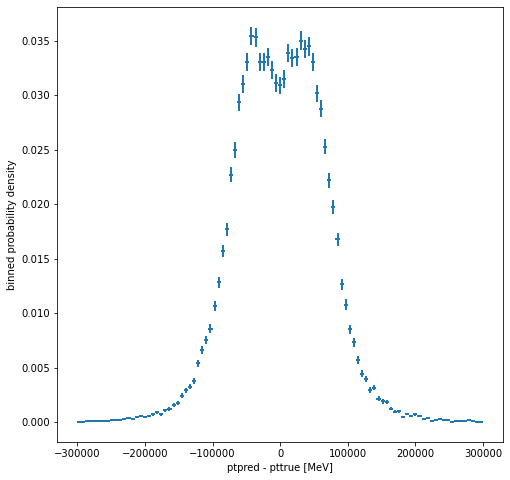

In [30]:
#Plot the distribution of tranverse momentum error.
fig = binneddensity(error_px_train, fixedbinning(-300000, 300000, 100),
                    xlabel="ptpred - pttrue [MeV]")
fig

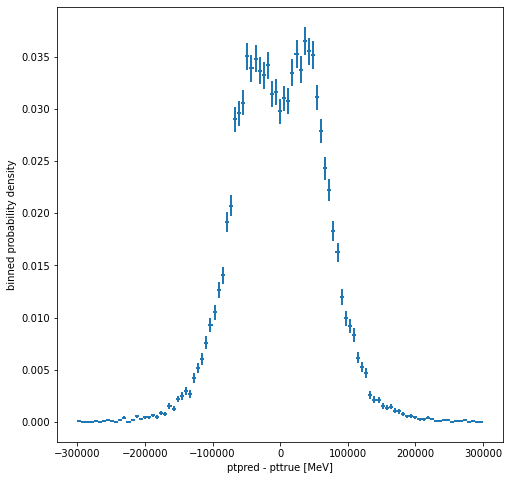

In [31]:
#Plot the distribution of tranverse momentum error.
fig = binneddensity(error_px_valid, fixedbinning(-300000, 300000, 100),
                    xlabel="ptpred - pttrue [MeV]")
fig

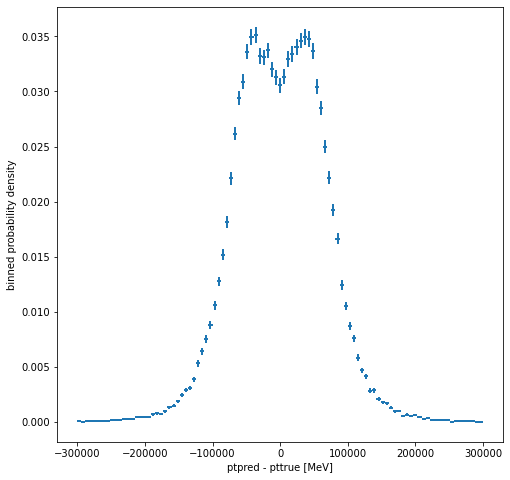

In [32]:
#Plot the distribution of tranverse momentum error.
fig = binneddensity(error_px, fixedbinning(-300000, 300000, 100),
                    xlabel="ptpred - pttrue [MeV]")
fig

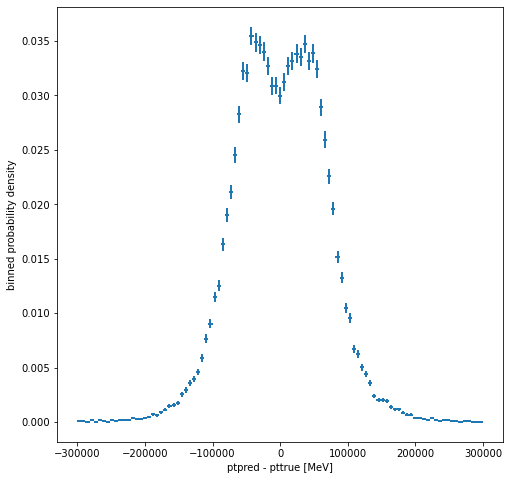

In [33]:
#Plot the distribution of tranverse momentum error.
fig = binneddensity(error_py_train, fixedbinning(-300000, 300000, 100),
                    xlabel="ptpred - pttrue [MeV]")
fig

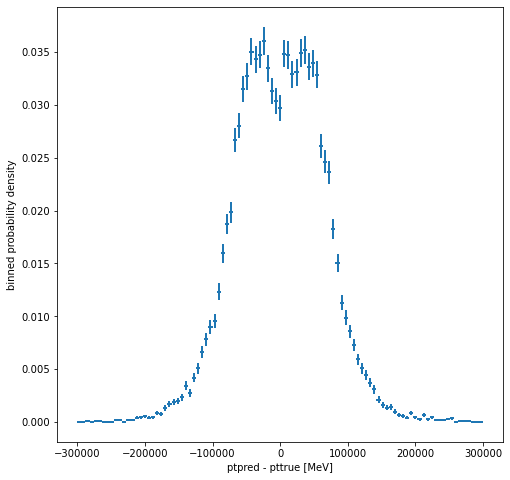

In [34]:
#Plot the distribution of tranverse momentum error.
fig = binneddensity(error_py_valid, fixedbinning(-300000, 300000, 100),
                    xlabel="ptpred - pttrue [MeV]")
fig

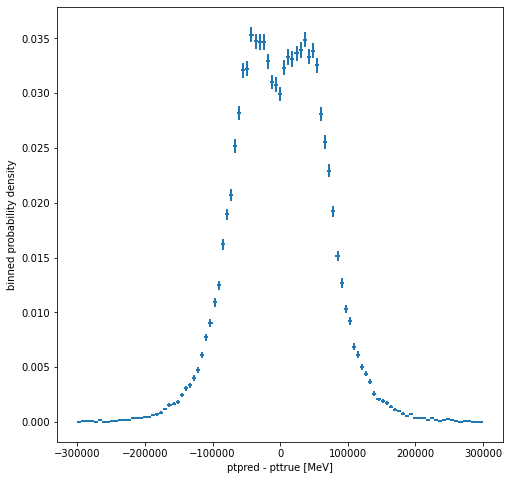

In [35]:
#Plot the distribution of tranverse momentum error.
fig = binneddensity(error_py, fixedbinning(-300000, 300000, 100),
                    xlabel="ptpred - pttrue [MeV]")
fig

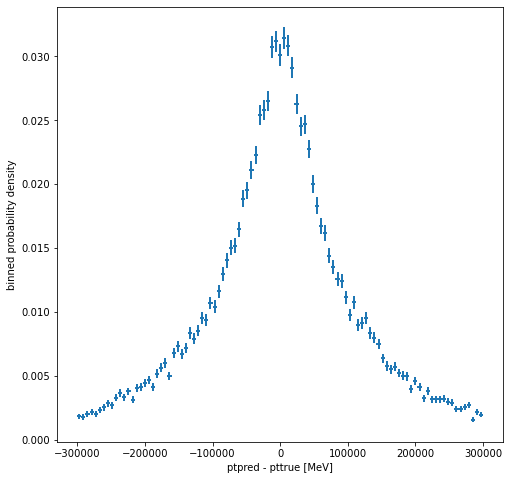

In [36]:
#Plot the distribution of tranverse momentum error.
fig = binneddensity(error_pz_train, fixedbinning(-300000, 300000, 100),
                    xlabel="ptpred - pttrue [MeV]")
fig

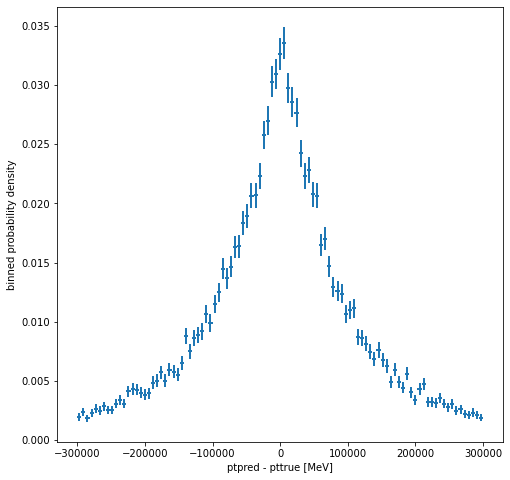

In [37]:
#Plot the distribution of tranverse momentum error.
fig = binneddensity(error_pz_valid, fixedbinning(-300000, 300000, 100),
                    xlabel="ptpred - pttrue [MeV]")
fig

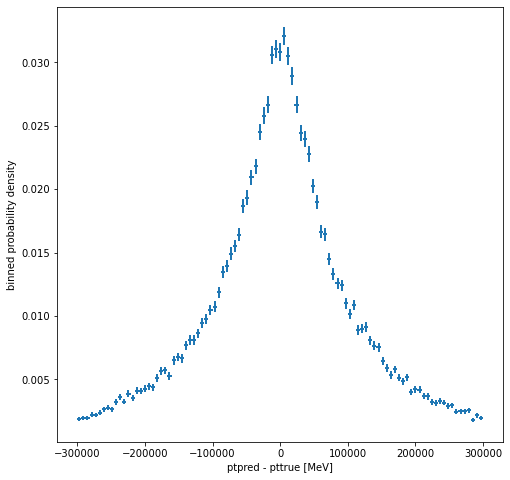

In [38]:
#Plot the distribution of tranverse momentum error.
fig = binneddensity(error_pz, fixedbinning(-300000, 300000, 100),
                    xlabel="ptpred - pttrue [MeV]")
fig

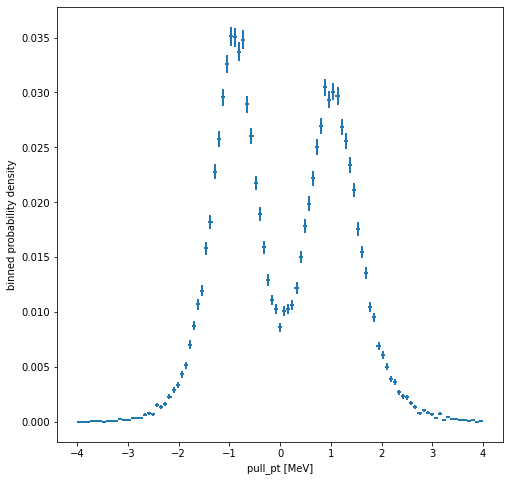

In [39]:
#Plot the distribution of tranverse momentum error.
fig = binneddensity(pull_px_train, fixedbinning(-4.0, 4.0, 100),
                    xlabel="pull_pt [MeV]")
fig

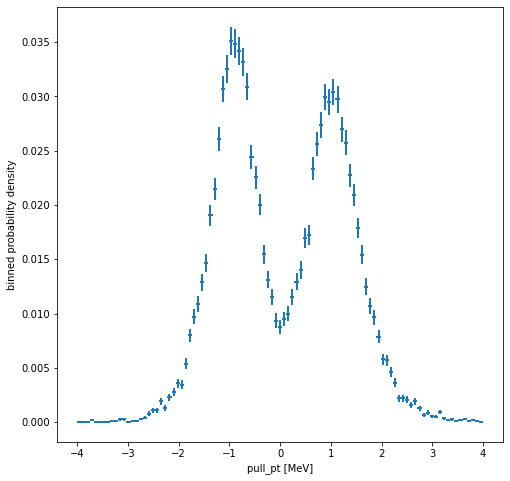

In [40]:
#Plot the distribution of tranverse momentum error.
fig = binneddensity(pull_px_valid, fixedbinning(-4.0, 4.0, 100),
                    xlabel="pull_pt [MeV]")
fig

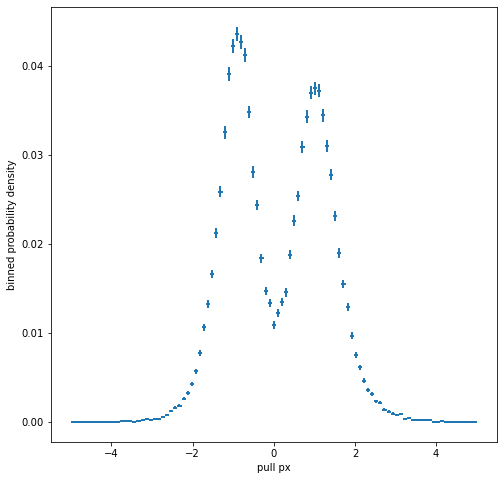

In [41]:
#Plot the distribution of tranverse momentum error.
fig = binneddensity(pull_px, fixedbinning(-5, 5, 100),
                    xlabel="pull px")
fig

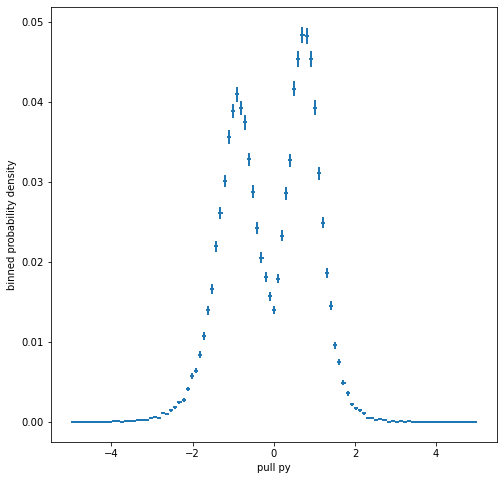

In [42]:
#Plot the distribution of tranverse momentum error.
fig = binneddensity(pull_py_train, fixedbinning(-5, 5, 100),
                    xlabel="pull py")
fig

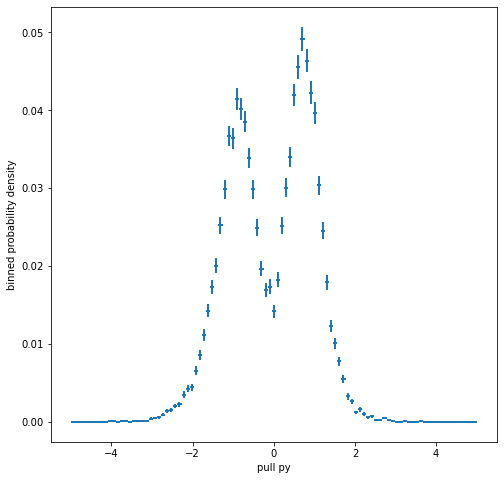

In [43]:
#Plot the distribution of tranverse momentum error.
fig = binneddensity(pull_py_valid, fixedbinning(-5, 5, 100),
                    xlabel="pull py")
fig

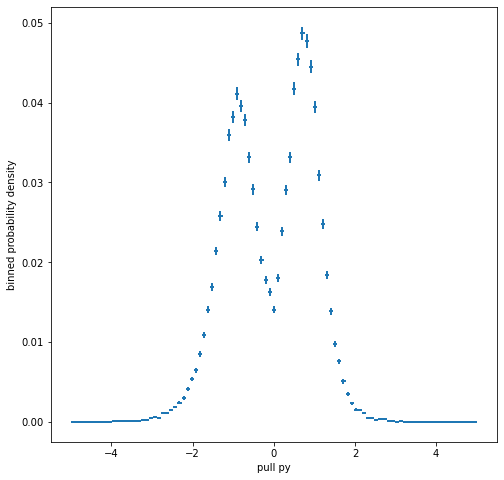

In [44]:
#Plot the distribution of tranverse momentum error.
fig = binneddensity(pull_py, fixedbinning(-5, 5, 100),
                    xlabel="pull py")
fig

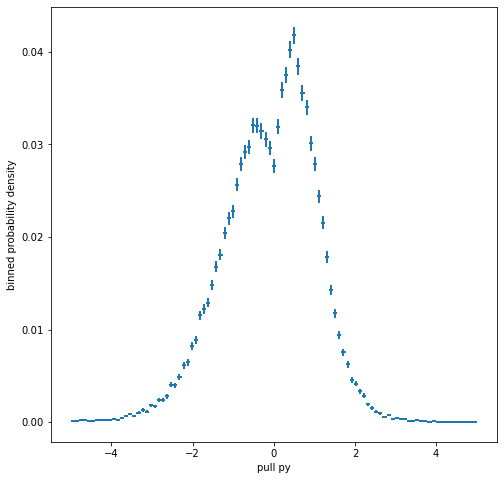

In [45]:
#Plot the distribution of tranverse momentum error.
fig = binneddensity(pull_pz_train, fixedbinning(-5, 5, 100),
                    xlabel="pull py")
fig

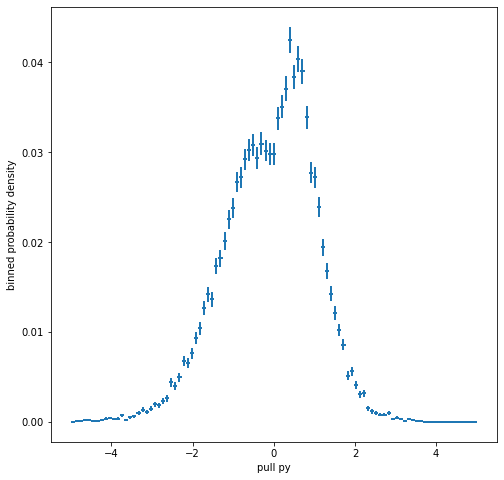

In [46]:
#Plot the distribution of tranverse momentum error.
fig = binneddensity(pull_pz_valid, fixedbinning(-5, 5, 100),
                    xlabel="pull py")
fig

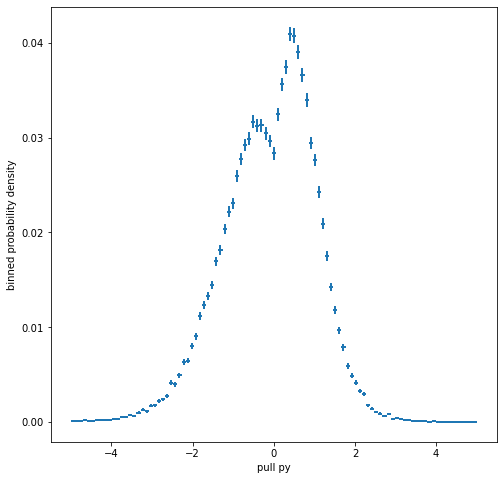

In [47]:
#Plot the distribution of tranverse momentum error.
fig = binneddensity(pull_pz, fixedbinning(-5, 5, 100),
                    xlabel="pull py")
fig

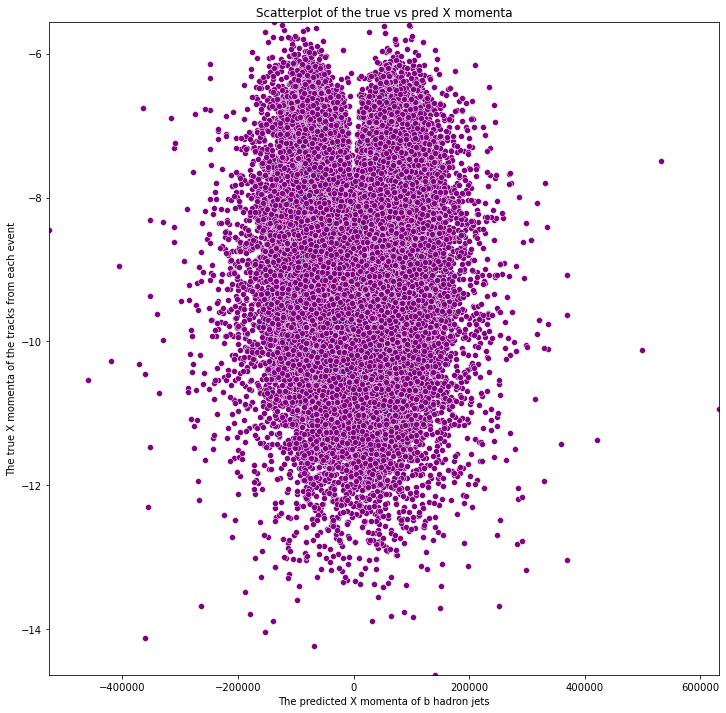

In [48]:
fig,ax = plt.subplots(figsize = (12,12))
sns.scatterplot(
    x = bhads[:,0],
    y = predictions[:,0],
    color = "purple"
)
ax.set_title("Scatterplot of the true vs pred X momenta")
ax.set_xlim([np.min(bhads[:,0]),np.max(bhads[:,0])])
ax.set_ylim([np.min(predictions[:,0]),np.max(predictions[:,0])])
ax.set_xlabel("The true X momenta of the tracks from each event")
ax.set_ylabel("The predicted X momenta of b hadron jets")
plt.show()

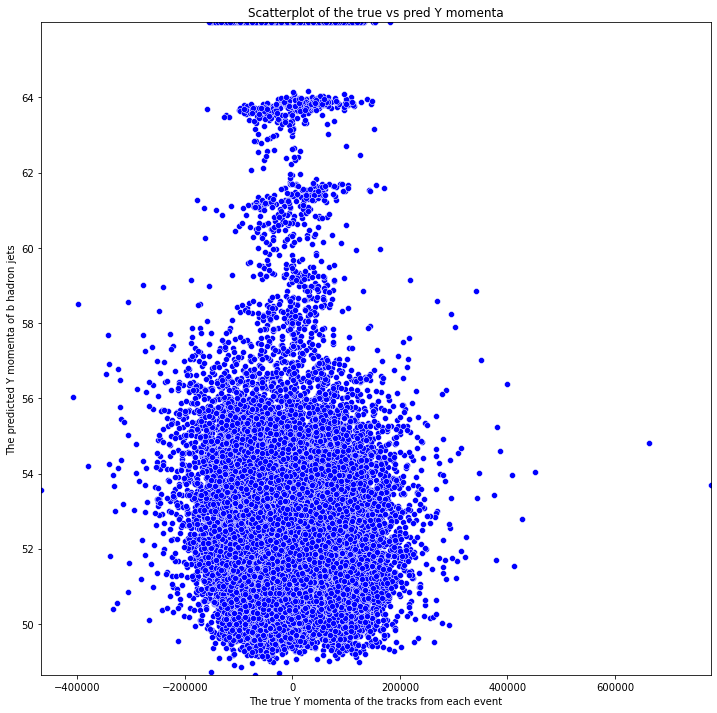

In [53]:
fig,ax = plt.subplots(figsize = (12,12))
sns.scatterplot(
    x = bhads[:,1],
    y = predictions[:,1],
    color = "blue"
)
ax.set_title("Scatterplot of the true vs pred Y momenta")
ax.set_xlim([np.min(bhads[:,1]),np.max(bhads[:,1])])
ax.set_ylim([np.min(predictions[:,1]),np.max(predictions[:,1])])
ax.set_xlabel("The true Y momenta of the tracks from each event")
ax.set_ylabel("The predicted Y momenta of b hadron jets")
plt.show()

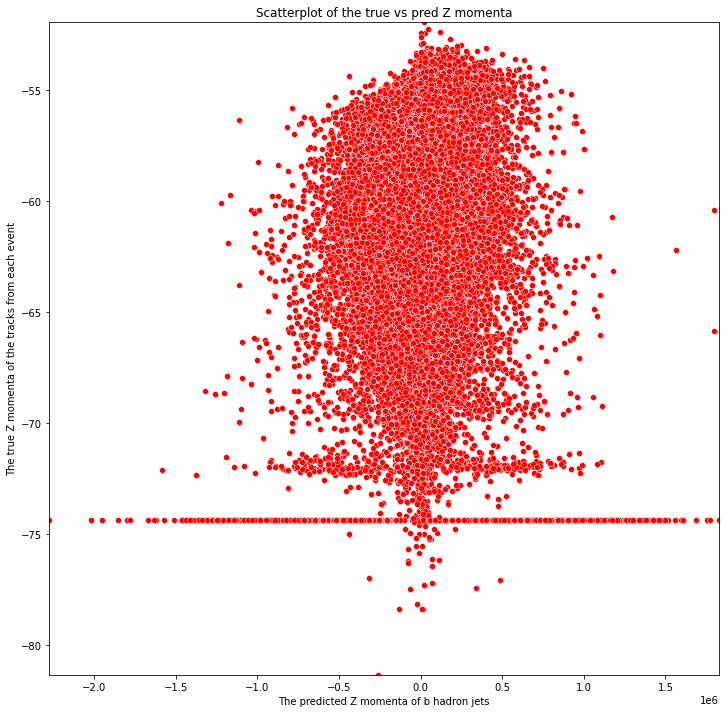

In [50]:
fig,ax = plt.subplots(figsize = (12,12))
sns.scatterplot(
    x = bhads[:,2],
    y = predictions[:,2],
    color = "red"
)
ax.set_title("Scatterplot of the true vs pred Z momenta")
ax.set_xlim([np.min(bhads[:,2]),np.max(bhads[:,2])])
ax.set_ylim([np.min(predictions[:,2]),np.max(predictions[:,2])])
ax.set_xlabel("The true Z momenta of the tracks from each event")
ax.set_ylabel("The predicted Z momenta of b hadron jets")
plt.show()

In [51]:
#Evaluate the entire performance of the model
loss = DeepNet.evaluate(tracks,bhads,verbose = 2)
print("The Loaded DeepNet has loss: ", loss,3)

2130/2130 - 4s - loss: 34.9621 - Normal_Accuracy_Metric: 100.1603 - 4s/epoch - 2ms/step
The Loaded DeepNet has loss:  [34.96211242675781, 100.16029357910156] 3


In [52]:
X_1= np.ma.masked_equal(tracks[:,:,0],-999)
ForestRegressor = RandomForestRegressor(n_estimators = 200, max_depth = 14, random_state = 42)
ForestRegressor.fit(X_1,bhads[:,0])

RandomForestRegressor(max_depth=14, n_estimators=200, random_state=42)

In [54]:
X_1 = np.ma.masked_equal(tracks[:,:,0],-999)
ForestRegressor.score(X_1,bhads[:,0])

0.9130950591541868

In [69]:
Predictions = ForestRegressor.predict(X_1)
mean = np.mean(Predictions)
std = np.std(Predictions)
Pull_RandomForest = (Predictions - bhads[:,0])/std
mean2 = np.mean(Pull_RandomForest)
std2 = np.std(Pull_RandomForest)
print(mean,std)
print(mean2,std2)

73.4404356198843 59877.97623943057
-0.0006559996423606991 0.3209545562219314


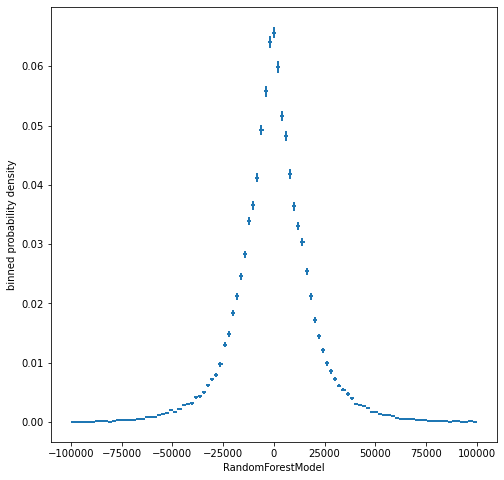

In [56]:
binneddensity(Predictions - bhads[:,0], fixedbinning(-100000,100000,100), xlabel ="RandomForestModel Error")

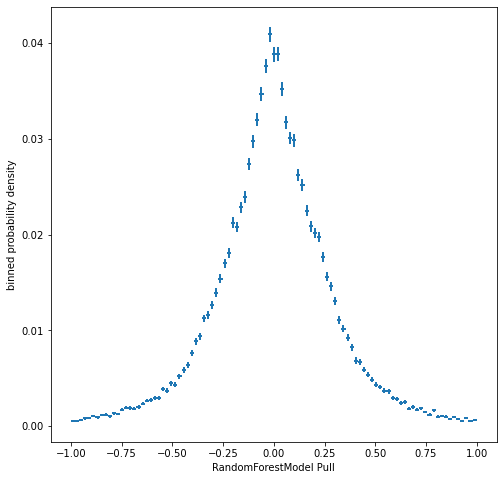

In [67]:
binneddensity(Pull_RandomForest, fixedbinning(-1,1,100), xlabel ="RandomForestModel Pull")

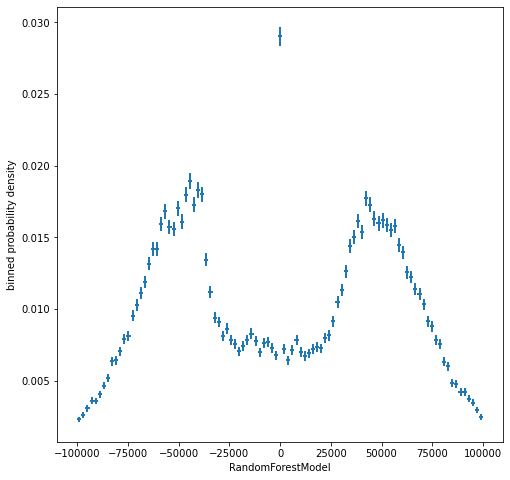

In [57]:
binneddensity(Predictions, fixedbinning(-100000,100000,100), xlabel ="RandomForestModel")

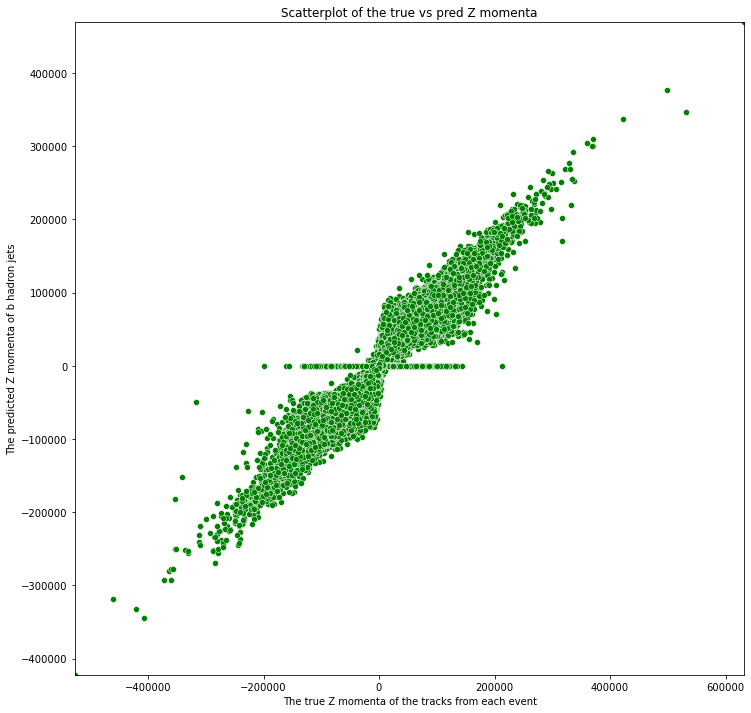

In [60]:
fig,ax = plt.subplots(figsize = (12,12))
sns.scatterplot(
    x = bhads[:,0],
    y = Predictions,
    color = "green"
)
ax.set_title("Scatterplot of the true vs pred Z momenta")
ax.set_xlim([np.min(bhads[:,0]),np.max(bhads[:,0])])
ax.set_ylim([np.min(Predictions),np.max(Predictions)])
ax.set_xlabel("The true Z momenta of the tracks from each event")
ax.set_ylabel("The predicted Z momenta of b hadron jets")
plt.show()